## Data Characteristics & Challenge
**Type:** The dataset is **Tabular Data** representing clinical records.
**Challenge:** High missingness (~90% in some features).
**Solution:** We filtered columns with >90% missing values and rows with no data. For remaining missing values, we used **Median Imputation** because clinical variables (like CRP) often have skewed distributions (outliers), making the mean unreliable.

## The Challenge: Missing Data
High missingness in clinical records requires careful imputation. The visualization below shows the percentage of missing values per feature **before** any filtering or imputation.

## Feature Scaling (Z-Score)
**Goal:** Prepare data for Clustering.
**Reasoning:** K-Means calculates **Euclidean Distances**. Without scaling, features with large values (e.g., Platelets ~200,000) would dominate features with small values (e.g., Creatinine ~1.0).
**Action:** Applied `StandardScaler` to transform all features to mean=0 and std=1.

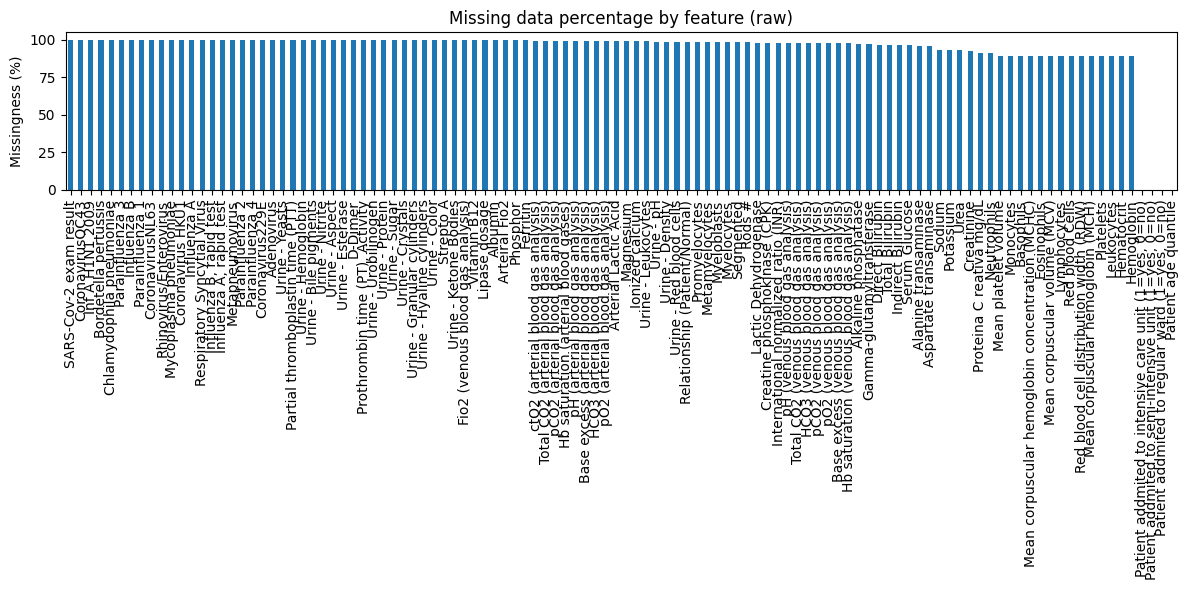

Patients retained: 603
Features retained: 37
Data were standardized (z-score) prior to saving.
Feature means (after scaling) summary:
count    3.700000e+01
mean     4.199849e-18
std      2.358537e-17
min     -2.945865e-17
25%     -1.178346e-17
50%      0.000000e+00
75%      1.472933e-17
max      8.248423e-17
dtype: float64
Feature stds (after scaling) summary:
count    3.700000e+01
mean     1.000000e+00
std      6.923457e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
Max |mean|: 0.0000
Std range: 1.0000 - 1.0000
Saved cleaned data to ..\data\processed\01_cleaned_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Paths
RAW_PATH = Path("../data/raw/dataset.xlsx")
OUT_PATH = Path("../data/processed/01_cleaned_data.csv")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

# Load
raw = pd.read_excel(RAW_PATH)
# Normalize column names
raw.columns = (raw.columns
               .str.replace(u"\xa0", " ", regex=False)
               .str.replace(r"\s+", " ", regex=True)
               .str.strip())

if "Patient ID" not in raw.columns:
    raise KeyError("'Patient ID' column is required.")

# Convert non-ID to numeric
non_id_cols = [c for c in raw.columns if c != "Patient ID"]
raw[non_id_cols] = raw[non_id_cols].apply(pd.to_numeric, errors="coerce")

# Visualize missingness before filtering/imputation
missing_pct = raw[non_id_cols].isna().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(12, 6))
missing_pct.plot(kind="bar")
plt.ylabel("Missingness (%)")
plt.title("Missing data percentage by feature (raw)")
plt.tight_layout()
plt.show()

# Targets to preserve (not scaled)
target_cols = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]

# Deduplicate by patient ID
df = raw.drop_duplicates(subset=["Patient ID"]).copy()
all_feature_cols = [c for c in df.columns if c != "Patient ID"]
lab_feature_cols = [c for c in all_feature_cols if c not in target_cols]
existing_targets = [c for c in target_cols if c in df.columns]

# Patient filter: >=10 non-missing labs (exclude target columns)
patient_counts = df[lab_feature_cols].notna().sum(axis=1)
df = df.loc[patient_counts >= 10].copy()

# Feature filter: <80% missing (exclude target columns)
missing_frac = df[lab_feature_cols].isna().mean()
kept_lab_features = missing_frac[missing_frac < 0.80].index.tolist()
final_cols = ["Patient ID"] + kept_lab_features + existing_targets

df = df[final_cols].copy()

# Impute + scale lab features only
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

imputed = imputer.fit_transform(df[kept_lab_features])
scaled = scaler.fit_transform(imputed)

processed = df.copy()
processed[kept_lab_features] = scaled

print(f"Patients retained: {processed.shape[0]}")
print(f"Features retained: {len(kept_lab_features)}")
print("Data were standardized (z-score) prior to saving.")

# Output validation: means ~0, stds ~1
feature_means = processed[kept_lab_features].mean()
feature_stds = processed[kept_lab_features].std(ddof=0)
print("Feature means (after scaling) summary:")
print(feature_means.describe())
print("Feature stds (after scaling) summary:")
print(feature_stds.describe())
print(f"Max |mean|: {feature_means.abs().max():.4f}")
print(f"Std range: {feature_stds.min():.4f} - {feature_stds.max():.4f}")

processed.to_csv(OUT_PATH, index=False)
print(f"Saved cleaned data to {OUT_PATH}")


### Data funnel and rationale (Quality over Quantity)
- **Funnel:** Initial patients → deduplicated → retained with ≤90% missing → final saved. See printed counts above for the exact numbers in this run.
- **Why discard ~90% missing profiles?** Patients with extremely sparse labs lack clinical signal (risk of garbage-in/garbage-out). We keep only those with a rich clinical profile (blood counts + metabolites) to ensure valid downstream inference.
- **Imputation is minimal:** Median imputation applied only after filtering to the retained patients/features; no broad filling of empty records.
- **Standardization:** Features are z-score scaled (StandardScaler) before export to align ranges for PCA/KMeans.
- **Handoff:** Cleaned, scaled dataframe is saved to `../data/processed/01_cleaned_data.csv` for the next notebook.

